In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = array[:,i*binsize:(i+1)*binsize]
    return(A)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike, k):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-k,k)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def spike_count(spikes, ax, num_bins = None, t_min = None, t_max = None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    binary = binarize(spikes)
    for i in range(n):
        spike_count.append(np.sum(binary[i][t_min:t_max]))
    if num_bins is None: num_bins = int(np.max(spike_count) - np.min(spike_count))
    n, bins, patches = ax.hist(spike_count, num_bins, color = 'blue')
    ax.set_title("Spike Rate Distribution")
    ax.set_xlabel("Total Number of Spikes", fontsize = 22)
    ax.set_ylabel("Number of Neurons", fontsize = 22)
    return(n,bins)

# Describe merging communities

In [3]:
spike_rate = [10, 30, 20] # spike rate per merging event. communities merge by changing their firing rate
comm_sizes = [[30,5,20,5,20,10,10],[35,25,40],[100]] # community sizes at every merging event
num_neurons = int(sum(comm_sizes[0]))
bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs
seconds = len(spike_rate)
total_duration = int(seconds*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
layers = int(total_duration/window_size)

In [4]:
spikes = np.zeros((num_neurons, total_duration))
for s in range(seconds):
    neuron_count = 0
    for i,e in enumerate(comm_sizes[s]):
        initial_master = homogeneous_poisson_process(rate = spike_rate[s]*Hz, t_start = s*(bin_size)*ms, t_stop = (s+1)*bin_size*ms, as_array=True)
        master_spikes = np.zeros((1,total_duration))
    
        for j,f in enumerate(initial_master):
            master_spikes[0][int(f)] = 1

        for j in range(e):
            spikes[neuron_count+j][int(s*bin_size):int((s+1)*bin_size)] = jitter(master_spikes[:,int(s*bin_size):int((s+1)*bin_size)], k)
        neuron_count = neuron_count + e

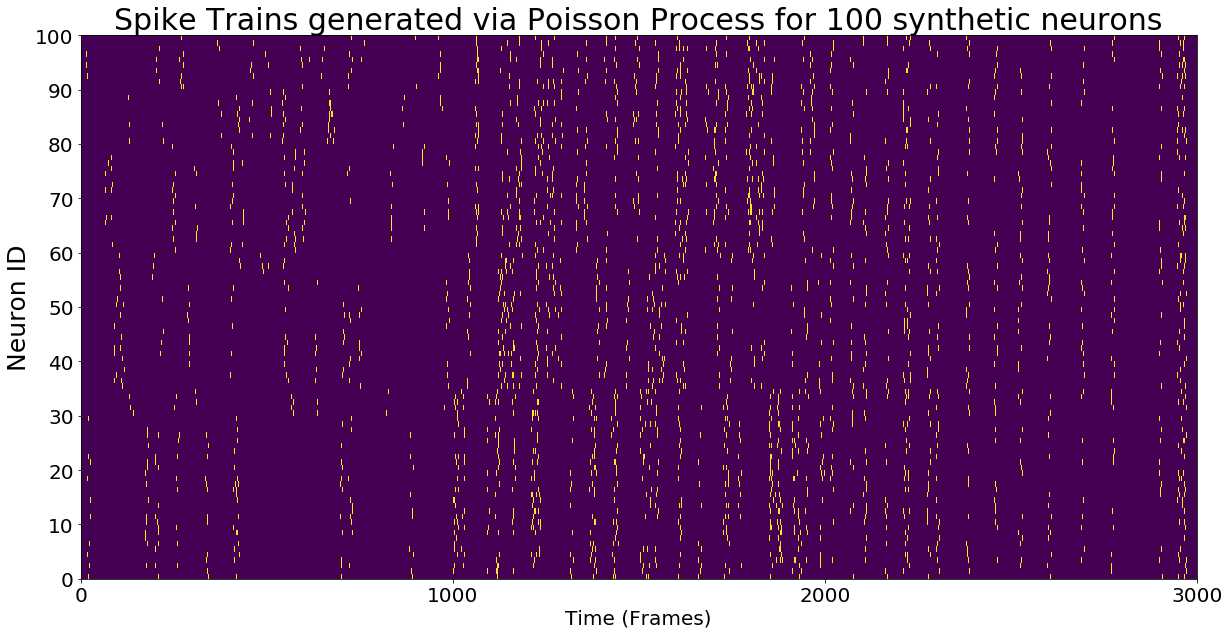

In [5]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,total_duration,0,num_neurons])
ax.set_title('Spike Trains generated via Poisson Process for %d synthetic neurons'%num_neurons, fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*1000 for j in range(int(total_duration/1000)+1)])
ax.set_yticks([i*10 for i in range(int(num_neurons/10)+1)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
#plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/spiketrain_synthetic.pdf')

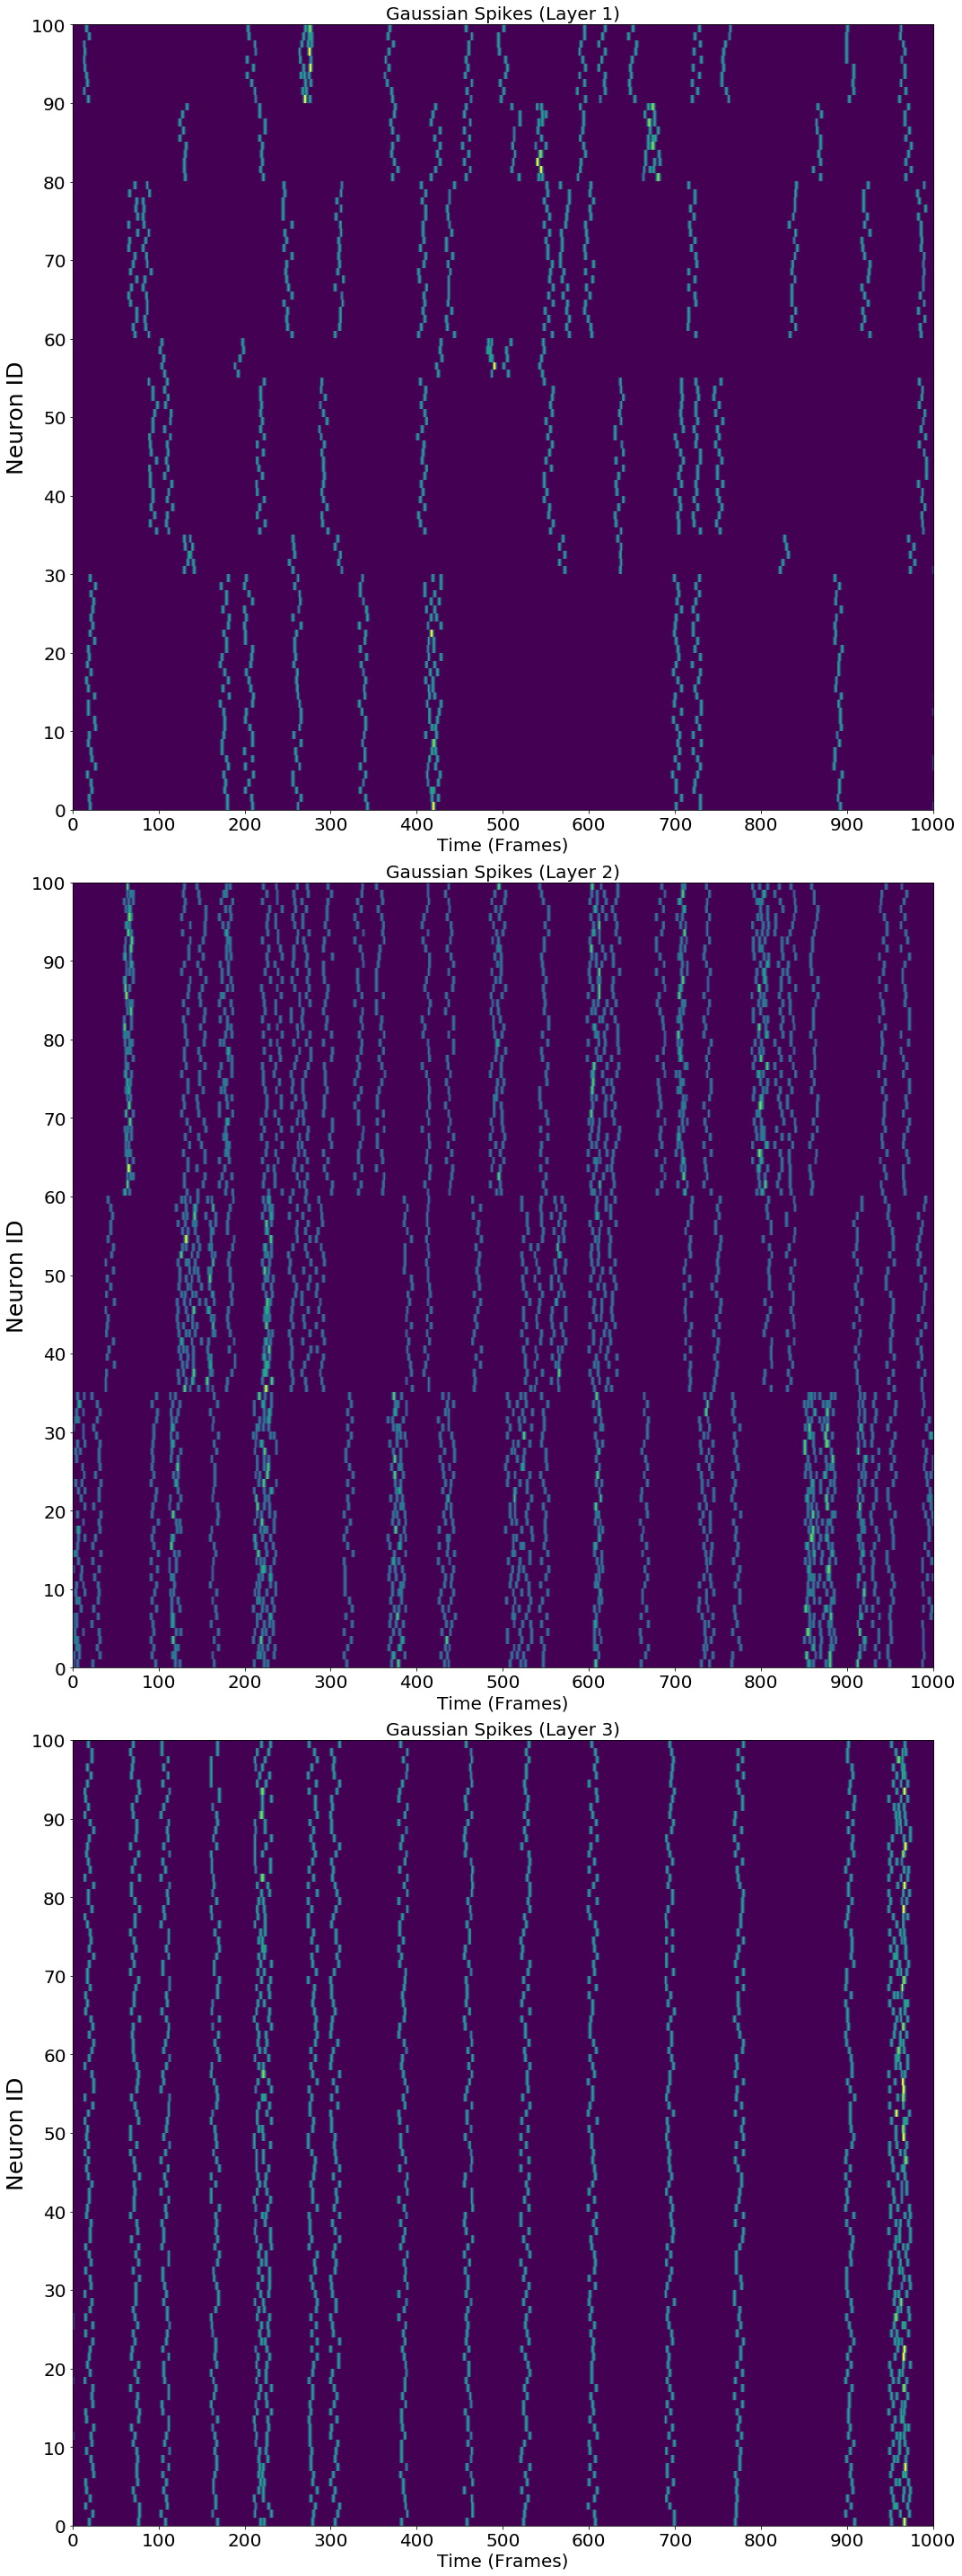

In [6]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,40))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto', extent = [0,1000,0,num_neurons])
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()
#plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/binned_spiketrain_synthetic.pdf')

In [7]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


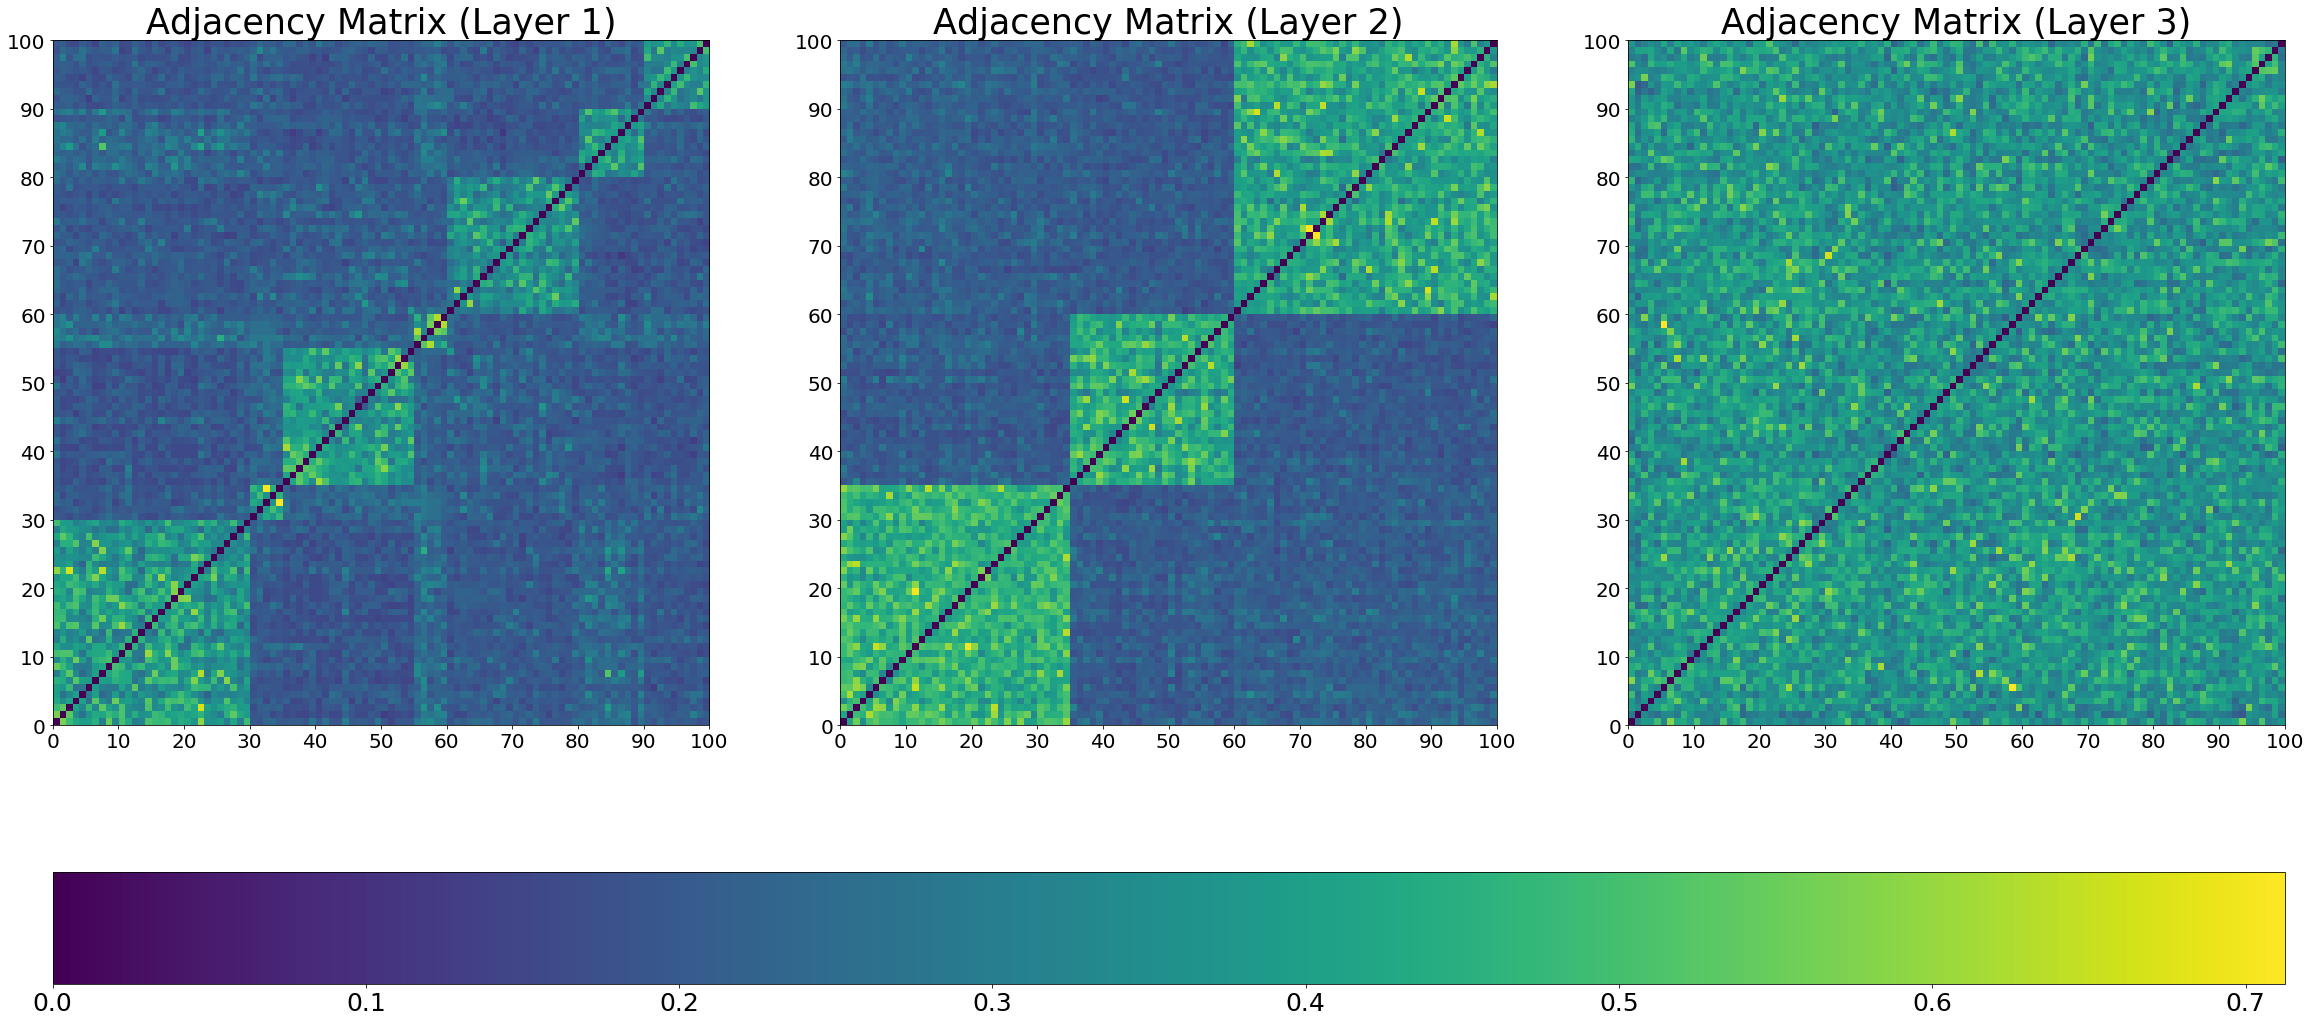

In [8]:
fig,ax = plt.subplots(1,layers, figsize = (40,18))
for i in range(layers):
    k = ax[i].imshow(adjacency_matrices[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 35)
    ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
    ax[i].tick_params(axis = 'both', labelsize = 20)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 
#plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/adjacency.pdf')